In [1]:
# PANDAS VE NUMPY KÜTÜPHANELERİNİ İÇE AKTARMA
import pandas as pd
import numpy as np

# SEABORN, MATPLOTLIB, SKLEARN VE TENSORFLOW KÜTÜPHANELERİNİ İÇE AKTARMA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# GOOGLE DRIVE BAĞLANTISI
from google.colab import drive
drive.mount('/content/drive')

# VERİ SETİNİ ÇIKARMA (FURKAN.ZIP ADLI DOSYAYI /CONTENT/ DİZİNİNE ÇIKARMA)
!unzip "/content/drive/MyDrive/furkan.zip" -d "/content/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/furkan.zip
replace /content/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

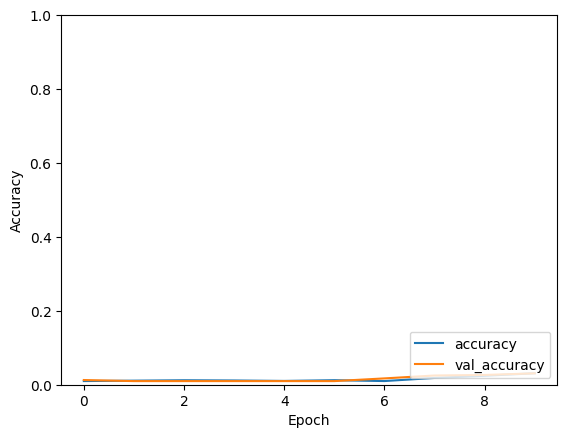

64/64 [==============================] - 1s 8ms/step
Validation Accuracy: 0.03080684596577017


In [2]:
# ETİKETLERİ İÇEREN CSV DOSYASINI YÜKLEME
labels_df = pd.read_csv("/content/labels.csv")

# EĞİTİM SETİNDEKİ GÖRÜNTÜLERİ İÇEREN DOSYAYI YÜKLEME
train_path = "/content/train/"
train_df = labels_df.copy()
train_df['filename'] = train_df.apply(lambda x: (train_path + x["id"] + ".jpg"), axis=1)

# KATEGORİK KODLAMAYI YAPMA
label_encoder = LabelEncoder()
train_df['breed_encoded'] = label_encoder.fit_transform(train_df['breed'])

# VERİYİ EĞİTİM VE DOĞRULAMA OLARAK BÖLELİM
X_train, X_val, y_train, y_val = train_test_split(train_df['filename'], train_df['breed_encoded'], test_size=0.2, random_state=42)

# GÖRÜNTÜLERİ YÜKLEYİP NORMALİZE ETME
def preprocess_image(file_path):
    img = load_img(file_path, target_size=(128, 128))
    img_array = img_to_array(img)
    return img_array / 255.0

X_train = np.array([preprocess_image(img_path) for img_path in X_train])
X_val = np.array([preprocess_image(img_path) for img_path in X_val])

# MODELİN GİRİŞ ŞEKLİNİ TANIMLAMA
input_shape = (128, 128, 3)

# MODELİ OLUŞTURMA
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# MODELİ DERLEME
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# MODELİN ÖZETİNİ YAZDIRMA
model.summary()

# MODELİ EĞİTME
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# EĞİTİM VE DOĞRULAMA DOĞRULUĞUNU, KAYBINI VE DOĞRULAMA KAYBINI ÇİZME
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# MODELİN DOĞRULUĞUNU DEĞERLENDİRME
y_pred = np.argmax(model.predict(X_val), axis=1)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {val_accuracy}")


In [ ]:
# EN İYİ DOĞRULAMA DOĞRULUĞU, EPOKLAR VE DROPOUT ORANI İÇİN DEĞİŞKENLERİ BAŞLATMA
best_val_accuracy = 0
best_epochs = 0
best_dropout_rate = 0

# DAHA BASİT BİR MODEL VE KISA EĞİTİM SÜRELERİ İÇİN DÖNGÜ
for epochs in [3, 5]:
    for dropout_rate in [0.3, 0.5]:
        # YENİ MODELİ OLUŞTURMA
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(len(label_encoder.classes_), activation='softmax'))

        # MODELİ DERLEME
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # MODELİ EĞİTME
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=32)

        # SON EPOKA İÇİN DOĞRULAMA DOĞRULUĞU
        val_accuracy = history.history['val_accuracy'][-1]

        # SONUÇLARI YAZDIRMA
        print(f"Epochs: {epochs}, Dropout: {dropout_rate}, Validation Accuracy: {val_accuracy}")

        # EN İYİ DOĞRULAMA DOĞRULUĞUNU KARŞILAŞTIRMA VE GÜNCELLEME
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epochs = epochs
            best_dropout_rate = dropout_rate

# EN İYİ DOĞRULAMA DOĞRULUĞU, EPOKLAR VE DROPOUT ORANI İLE SONUCU YAZDIRMA
print(f"Best Validation Accuracy: {best_val_accuracy} with Epochs: {best_epochs}, Dropout: {best_dropout_rate}")


Epochs: 3, Dropout: 0.3, Validation Accuracy: 0.00977995153516531


NOT: YURAKIDAKİ SATIRDA SÜREKLİ YÜKSEK BELLEK KULLANIMINDAN ÖTÜRÜ HATA VERİP PROGRAM ÇALIŞMAYI DURDURUYORDU.BİR TÜRLÜ BU DURUMU ÇÖZEMEDİM. EPOCH SAYISINI AZALTTIM OLMADI. PARAMETRELERİ DÜŞÜRDÜM OLMADI. BATCH SİZE'I DÜŞÜRDÜM OLMADI. BİRKAÇ KOMBİNASYON DENEMESİ YAPMAMA RAĞMEN BAŞARILI OLAMADIM. SÜREKLİ BELLEK HATASI YÜZÜNDEN TÜM İŞLEMLERİ YENİDEN YAPMAK ZORUNDA KALDIM. BEN DE BÖYLE BIRAKMAK ZORUNDA KALDIM. BU YÜZDEN AŞAĞIDAKİ HÜCRE TEST VERİ SETİ ÜZERİNDE TAHMİN YAPMAK İÇİN YAZILMIŞTI AMA ÇALIŞTIRAMAĞIM İÇİN DOĞRULUĞUNDAN EMİN DEĞİLİM.

In [ ]:
# TEST VERİ SETİNİ YÜKLEME
test_path = "/content/test/"
test_df = pd.read_csv("/content/sample_submission.csv")

# TEST SETİNDEKİ GÖRÜNTÜLERİ İÇEREN DOSYAYI YÜKLEME
test_df['filename'] = test_df.apply(lambda x: (test_path + x["id"] + ".jpg"), axis=1)

# TEST SETİNİ NORMALİZE ETME
X_test = np.array([preprocess_image(img_path) for img_path in test_df['filename']])

# MODELİN PERFORMANSINI DEĞERLENDİRME
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# ÖRNEK OLARAK, CONFUSION MATRIX VE SINIFLANDIRMA RAPORU YAZDIRMA
conf_matrix = confusion_matrix(test_df['breed_encoded'], y_test_pred)
class_report = classification_report(test_df['breed_encoded'], y_test_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
